# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


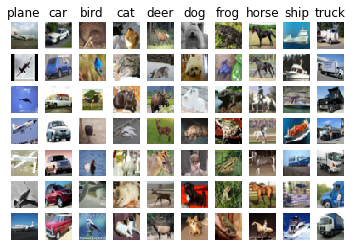

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [7]:
a = np.random.choice(100,3,replace = True)
print(a)

[95 84  6]


(3072,)
[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


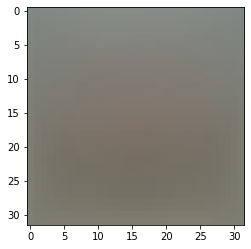

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.444695


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.751144 analytic: -4.751144, relative error: 1.560389e-10
numerical: -14.340529 analytic: -14.340529, relative error: 1.474068e-11
numerical: 10.529608 analytic: 10.529608, relative error: 5.958440e-12
numerical: -1.969143 analytic: -1.969143, relative error: 8.638256e-11
numerical: 16.050897 analytic: 16.050897, relative error: 4.636420e-12
numerical: -0.811317 analytic: -0.811317, relative error: 4.862295e-10
numerical: 5.773255 analytic: 5.773255, relative error: 2.897829e-11
numerical: -21.742906 analytic: -21.742906, relative error: 1.016612e-11
numerical: 23.224508 analytic: 23.224508, relative error: 3.541010e-12
numerical: -4.593438 analytic: -4.593438, relative error: 1.510975e-10
numerical: -25.662935 analytic: -25.665952, relative error: 5.876989e-05
numerical: 11.988599 analytic: 11.988866, relative error: 1.113007e-05
numerical: 16.886923 analytic: 16.887158, relative error: 6.950531e-06
numerical: 6.110722 analytic: 6.112576, relative error: 1.516247e-04
nume

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [34]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.444695e+00 computed in 0.123981s
Vectorized loss: 9.444695e+00 computed in 0.005042s
difference: 0.000000


In [25]:
num_train = X_dev.shape[0]
score = X_dev.dot(W)
print(score.shape)
t= score[range(num_train),list(y_dev)]
# print(t.reshape(-1,1).shape)
# print(score-t.reshape(-1,1))
a = np.array([[1,2,3,4],[5,6,7,8]])
print(np.sum(a,axis=0))
print(np.zeros((2,4)))
print(np.zeros(4,6))

(500, 10)
[ 6  8 10 12]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]


TypeError: data type not understood

In [35]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.128949s
Vectorized loss and gradient: computed in 0.005315s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [42]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 408.563012
iteration 100 / 1500: loss 240.324935
iteration 200 / 1500: loss 146.620437
iteration 300 / 1500: loss 90.412824
iteration 400 / 1500: loss 55.482551
iteration 500 / 1500: loss 35.124585
iteration 600 / 1500: loss 23.620731
iteration 700 / 1500: loss 15.720189
iteration 800 / 1500: loss 11.620552
iteration 900 / 1500: loss 9.142868
iteration 1000 / 1500: loss 7.938597
iteration 1100 / 1500: loss 6.703693
iteration 1200 / 1500: loss 6.435232
iteration 1300 / 1500: loss 5.355039
iteration 1400 / 1500: loss 5.349517
That took 6.041829s


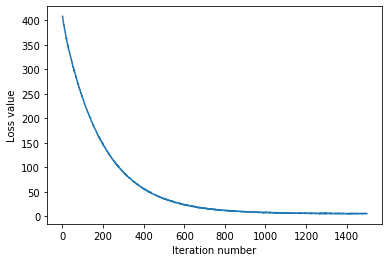

In [43]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [44]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.377204
validation accuracy: 0.384000


In [52]:
a = [(1+i*0.1)*1e4 for i in range(-3,3)] + [(2+0.1*i)*1e4 for i in range(-3,3)]
print(a)
b = [1e4 +0.05e4*i for i in range(50)]
print(b)


[7000.0, 8000.0, 9000.0, 10000.0, 11000.0, 12000.0, 17000.0, 18000.0, 19000.0, 20000.0, 21000.0, 22000.0]
[10000.0, 11000.0, 12000.0, 13000.0, 14000.0, 15000.0, 16000.0, 17000.0, 18000.0, 19000.0, 20000.0, 21000.0, 22000.0, 23000.0, 24000.0, 25000.0, 26000.0, 27000.0, 28000.0, 29000.0, 30000.0, 31000.0, 32000.0, 33000.0, 34000.0, 35000.0, 36000.0, 37000.0, 38000.0, 39000.0, 40000.0, 41000.0, 42000.0, 43000.0, 44000.0, 45000.0, 46000.0, 47000.0, 48000.0, 49000.0, 50000.0, 51000.0, 52000.0, 53000.0, 54000.0, 55000.0, 56000.0, 57000.0, 58000.0, 59000.0]


In [68]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1.405e-7,1.61e-7,1.715e-7]
regularization_strengths =[1.8e4+0.02e4*i for i in range(10)]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_com = None;
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

tmp_iters = 3000
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss = svm.train(X_train,y_train,learning_rate = lr,reg = rs,num_iters = tmp_iters,verbose = True)
        train_pred = svm.predict(X_train)
        train_acc = np.mean(train_pred == y_train)
        val_pred = svm.predict(X_val)
        val_acc = np.mean(val_pred==y_val)
        if(val_acc > best_val):
            best_val = val_acc
            best_svm = svm
            best_com = (lr,rs)
        results[(lr,rs)] = (train_acc,val_acc)
        
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
print(best_com)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 3000: loss 297.099107
iteration 100 / 3000: loss 172.521182
iteration 200 / 3000: loss 105.816508
iteration 300 / 3000: loss 64.442027
iteration 400 / 3000: loss 40.636788
iteration 500 / 3000: loss 26.178851
iteration 600 / 3000: loss 17.694312
iteration 700 / 3000: loss 11.888087
iteration 800 / 3000: loss 9.494098
iteration 900 / 3000: loss 7.527501
iteration 1000 / 3000: loss 6.587052
iteration 1100 / 3000: loss 6.032357
iteration 1200 / 3000: loss 5.887767
iteration 1300 / 3000: loss 5.471190
iteration 1400 / 3000: loss 5.100543
iteration 1500 / 3000: loss 5.475486
iteration 1600 / 3000: loss 4.736399
iteration 1700 / 3000: loss 4.323760
iteration 1800 / 3000: loss 5.272605
iteration 1900 / 3000: loss 5.128137
iteration 2000 / 3000: loss 4.758769
iteration 2100 / 3000: loss 4.705451
iteration 2200 / 3000: loss 4.969530
iteration 2300 / 3000: loss 4.963093
iteration 2400 / 3000: loss 5.388677
iteration 2500 / 3000: loss 4.825523
iteration 2600 / 3000: loss 4.461630
it

iteration 1200 / 3000: loss 5.390104
iteration 1300 / 3000: loss 5.472792
iteration 1400 / 3000: loss 4.841485
iteration 1500 / 3000: loss 5.177668
iteration 1600 / 3000: loss 5.035862
iteration 1700 / 3000: loss 5.182734
iteration 1800 / 3000: loss 4.913507
iteration 1900 / 3000: loss 5.175915
iteration 2000 / 3000: loss 4.714228
iteration 2100 / 3000: loss 5.219173
iteration 2200 / 3000: loss 4.928662
iteration 2300 / 3000: loss 5.295323
iteration 2400 / 3000: loss 4.969207
iteration 2500 / 3000: loss 5.569293
iteration 2600 / 3000: loss 5.118382
iteration 2700 / 3000: loss 5.055472
iteration 2800 / 3000: loss 4.871961
iteration 2900 / 3000: loss 4.701867
iteration 0 / 3000: loss 319.508512
iteration 100 / 3000: loss 178.664854
iteration 200 / 3000: loss 104.753672
iteration 300 / 3000: loss 61.508740
iteration 400 / 3000: loss 37.685878
iteration 500 / 3000: loss 24.288973
iteration 600 / 3000: loss 15.520471
iteration 700 / 3000: loss 11.092399
iteration 800 / 3000: loss 8.283752
i

iteration 2400 / 3000: loss 4.531518
iteration 2500 / 3000: loss 5.243795
iteration 2600 / 3000: loss 4.619441
iteration 2700 / 3000: loss 5.075602
iteration 2800 / 3000: loss 4.949403
iteration 2900 / 3000: loss 4.914508
iteration 0 / 3000: loss 312.924400
iteration 100 / 3000: loss 166.348652
iteration 200 / 3000: loss 90.210595
iteration 300 / 3000: loss 51.005993
iteration 400 / 3000: loss 29.653003
iteration 500 / 3000: loss 18.974331
iteration 600 / 3000: loss 12.349048
iteration 700 / 3000: loss 9.015152
iteration 800 / 3000: loss 7.531549
iteration 900 / 3000: loss 6.455211
iteration 1000 / 3000: loss 5.283294
iteration 1100 / 3000: loss 5.948500
iteration 1200 / 3000: loss 4.502658
iteration 1300 / 3000: loss 4.660151
iteration 1400 / 3000: loss 5.272938
iteration 1500 / 3000: loss 4.940809
iteration 1600 / 3000: loss 4.853700
iteration 1700 / 3000: loss 4.387240
iteration 1800 / 3000: loss 5.168982
iteration 1900 / 3000: loss 5.055011
iteration 2000 / 3000: loss 5.261881
iter

iteration 600 / 3000: loss 10.957328
iteration 700 / 3000: loss 8.942763
iteration 800 / 3000: loss 6.527929
iteration 900 / 3000: loss 5.819058
iteration 1000 / 3000: loss 5.583171
iteration 1100 / 3000: loss 5.199055
iteration 1200 / 3000: loss 5.316026
iteration 1300 / 3000: loss 5.431658
iteration 1400 / 3000: loss 4.561244
iteration 1500 / 3000: loss 4.679500
iteration 1600 / 3000: loss 5.001279
iteration 1700 / 3000: loss 5.598531
iteration 1800 / 3000: loss 4.809787
iteration 1900 / 3000: loss 5.738684
iteration 2000 / 3000: loss 5.473532
iteration 2100 / 3000: loss 4.766606
iteration 2200 / 3000: loss 4.906776
iteration 2300 / 3000: loss 5.041490
iteration 2400 / 3000: loss 4.567145
iteration 2500 / 3000: loss 4.794272
iteration 2600 / 3000: loss 4.899907
iteration 2700 / 3000: loss 4.977141
iteration 2800 / 3000: loss 4.980549
iteration 2900 / 3000: loss 4.510959
iteration 0 / 3000: loss 308.616655
iteration 100 / 3000: loss 156.443430
iteration 200 / 3000: loss 83.745759
iter

iteration 1900 / 3000: loss 5.354770
iteration 2000 / 3000: loss 4.788567
iteration 2100 / 3000: loss 4.908799
iteration 2200 / 3000: loss 4.489011
iteration 2300 / 3000: loss 4.646441
iteration 2400 / 3000: loss 4.963429
iteration 2500 / 3000: loss 5.396263
iteration 2600 / 3000: loss 5.323652
iteration 2700 / 3000: loss 4.980702
iteration 2800 / 3000: loss 4.784900
iteration 2900 / 3000: loss 5.240571
lr 1.405000e-07 reg 1.800000e+04 train accuracy: 0.384837 val accuracy: 0.387000
lr 1.405000e-07 reg 1.820000e+04 train accuracy: 0.384653 val accuracy: 0.396000
lr 1.405000e-07 reg 1.840000e+04 train accuracy: 0.374633 val accuracy: 0.375000
lr 1.405000e-07 reg 1.860000e+04 train accuracy: 0.387531 val accuracy: 0.395000
lr 1.405000e-07 reg 1.880000e+04 train accuracy: 0.384204 val accuracy: 0.385000
lr 1.405000e-07 reg 1.900000e+04 train accuracy: 0.382796 val accuracy: 0.396000
lr 1.405000e-07 reg 1.920000e+04 train accuracy: 0.382837 val accuracy: 0.379000
lr 1.405000e-07 reg 1.9400

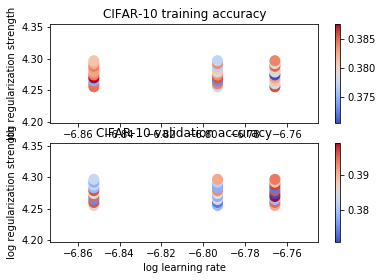

In [69]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [70]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.384000


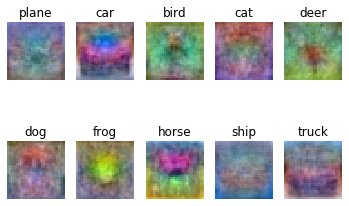

In [71]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
